# Madness of March
## Jim Haines & Josh McCoy
### [Project Website](https://joshmccoy2.github.io/NCAA_March_Madness/)

## Current Datasets
[Kaggle datasets](https://www.kaggle.com/competitions/mens-march-mania-2022/data)

# ETL & EDA

In [1]:
# Import necessary libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import requests
import numpy as np
import csv
import re
import time
import Levenshtein 
from io import StringIO
from io import StringIO
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from scipy.special import expit 
from scipy.special import expit  
from xgboost import XGBClassifier
from bs4 import BeautifulSoup

We can first look at how some basic factors affect the amount the winning team wins by. We want to look at the difference in score to see how dominant a team is against a competitor. A team who wins by a lot is typically a sign that this team is significantly better than its oponent.

In [2]:
# To do this we can look at regular season game stats
detailed_results_data = 'MRegularSeasonDetailedResults.csv'
detailed_results = pd.read_csv(detailed_results_data)
detailed_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76,H,0,28,67,...,13,15,23,5,24,10,15,3,5,21
100419,2022,98,1411,66,1126,63,A,0,24,59,...,21,15,24,5,23,10,19,13,2,23
100420,2022,98,1422,68,1441,49,A,0,23,56,...,24,8,11,10,18,5,16,8,2,12
100421,2022,98,1438,69,1181,68,A,0,31,65,...,17,18,22,11,25,14,14,3,9,11



Let's check the datatypes

In [3]:
detailed_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

All the dtypes look correct, so lets move on to our analysis

In [4]:
# Create variable for amount by which winning team wins
detailed_results['SCOREDIFF'] = detailed_results['WScore'] - detailed_results['LScore']

When you see W or L this stands for Winning or Losing team.

In [5]:
# Winner stats
detailed_results.dtypes
detailed_results['WFGPCT'] = detailed_results['WFGM']/detailed_results['WFGA']       # field goal pt completion %
detailed_results['W3PCT'] = detailed_results['WFGM3']/detailed_results['WFGA3']      # 3 pt completion %
detailed_results['WFTPCT'] = detailed_results['WFTM']/detailed_results['WFTA']       # free throw completion %
detailed_results['WORBCHANCE'] =  detailed_results['WOR'] + detailed_results['LDR']  # total potential rebounds
detailed_results['WORPCT'] = detailed_results['WOR']/detailed_results['WORBCHANCE']  # rebound completion %

In [6]:
# Losing stats
detailed_results['LFGPCT'] = detailed_results['LFGM']/detailed_results['LFGA']       
detailed_results['L3PCT'] = detailed_results['LFGM3']/detailed_results['LFGA3']
detailed_results['LFTPCT'] = detailed_results['LFTM']/detailed_results['LFTA']
detailed_results['LORBCHANCE'] =  detailed_results['LOR'] + detailed_results['WDR']
detailed_results['LORPCT'] = detailed_results['LOR']/detailed_results['LORBCHANCE']

We can now take a more detailed look at the correlation between winner field goal % and score difference.

We can look at other factors as well:

Despite the common phrase "board man gets paid", we can see that there is a less strong correlation between rebound % and score difference. Perhaps this saying holds more true a higher level of play.

We can also take a look at detailed results from the actual tournament to see if there are any obvious differences from the regular season data. To do this we can replicate the above regular season analysis.

In [7]:
detailed_tourney_data = 'MNCAATourneyDetailedResults.csv'
detailed_tourney_results = pd.read_csv(detailed_tourney_data)
detailed_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,15,14,19,7,20,9,9,7,0,13
1177,2021,148,1417,51,1276,49,N,0,21,54,...,11,6,11,8,24,12,14,5,3,11
1178,2021,152,1124,78,1222,59,N,0,29,55,...,19,11,16,13,12,10,10,4,5,10
1179,2021,152,1211,93,1417,90,N,1,37,63,...,17,14,21,7,24,21,9,4,1,16


In [8]:
detailed_tourney_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

In [9]:
#Create variable for amount by which winning team wins
detailed_tourney_results['SCOREDIFF'] = detailed_tourney_results['WScore'] - detailed_tourney_results['LScore']

In [10]:
# Winner stats
detailed_tourney_results.dtypes
detailed_tourney_results['WFGPCT'] = detailed_tourney_results['WFGM']/detailed_tourney_results['WFGA']       # field goal pt completion %
detailed_tourney_results['W3PCT'] = detailed_tourney_results['WFGM3']/detailed_tourney_results['WFGA3']      # 3 pt completion %
detailed_tourney_results['WFTPCT'] = detailed_tourney_results['WFTM']/detailed_tourney_results['WFTA']       # free throw completion %
detailed_tourney_results['WORBCHANCE'] =  detailed_tourney_results['WOR'] + detailed_tourney_results['LDR']  # total potential rebounds
detailed_tourney_results['WORPCT'] = detailed_tourney_results['WOR']/detailed_tourney_results['WORBCHANCE']  # rebound completion %

In [11]:
# Losing stats
detailed_tourney_results['LFGPCT'] = detailed_tourney_results['LFGM']/detailed_tourney_results['LFGA']       
detailed_tourney_results['L3PCT'] = detailed_tourney_results['LFGM3']/detailed_tourney_results['LFGA3']
detailed_tourney_results['LFTPCT'] = detailed_tourney_results['LFTM']/detailed_tourney_results['LFTA']
detailed_tourney_results['LORBCHANCE'] =  detailed_tourney_results['LOR'] + detailed_tourney_results['WDR']
detailed_tourney_results['LORPCT'] = detailed_tourney_results['LOR']/detailed_tourney_results['LORBCHANCE']

In [12]:
detailed_tourney_results.dtypes

Season          int64
DayNum          int64
WTeamID         int64
WScore          int64
LTeamID         int64
LScore          int64
WLoc           object
NumOT           int64
WFGM            int64
WFGA            int64
WFGM3           int64
WFGA3           int64
WFTM            int64
WFTA            int64
WOR             int64
WDR             int64
WAst            int64
WTO             int64
WStl            int64
WBlk            int64
WPF             int64
LFGM            int64
LFGA            int64
LFGM3           int64
LFGA3           int64
LFTM            int64
LFTA            int64
LOR             int64
LDR             int64
LAst            int64
LTO             int64
LStl            int64
LBlk            int64
LPF             int64
SCOREDIFF       int64
WFGPCT        float64
W3PCT         float64
WFTPCT        float64
WORBCHANCE      int64
WORPCT        float64
LFGPCT        float64
L3PCT         float64
LFTPCT        float64
LORBCHANCE      int64
LORPCT        float64
dtype: obj

In [13]:
detailed_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WFGPCT,W3PCT,WFTPCT,WORBCHANCE,WORPCT,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.463768,0.379310,0.653846,42,0.333333,0.432836,0.387097,0.451613,47,0.361702
1,2003,136,1112,80,1436,51,N,0,31,66,...,0.469697,0.304348,0.785714,37,0.297297,0.312500,0.250000,1.000000,44,0.181818
2,2003,136,1113,84,1272,71,N,0,31,59,...,0.525424,0.428571,0.727273,32,0.312500,0.362319,0.250000,0.666667,47,0.425532
3,2003,136,1141,79,1166,73,N,0,29,53,...,0.547170,0.428571,0.720000,28,0.392857,0.450000,0.411765,0.705882,34,0.411765
4,2003,136,1143,76,1301,74,N,1,27,64,...,0.421875,0.350000,0.652174,44,0.409091,0.446429,0.428571,0.750000,30,0.333333


In [14]:
# mteams_df = pd.read_csv('MTeams.csv')

# # Assuming df_team_data is your first dataframe containing data about the teams
# # df_seed_data is your second dataframe containing team IDs and their associated seed in a tournament
# # and you have columns WTeamID and LTeamID in df_team_data

# # Merge for WTeamID
# merged_df_winning = pd.merge(detailed_tourney_results, mteams_df, left_on=['WTeamID'], right_on=['TeamID'], how='left')
# merged_df_winning.rename(columns={'TeamName': 'TeamName1'}, inplace=True)

# # Merge for LTeamID
# merged_df_losing = pd.merge(detailed_tourney_results, mteams_df, left_on=['LTeamID'], right_on=['TeamID'], how='left')
# merged_df_losing.rename(columns={'TeamName': 'TeamName2'}, inplace=True)

# # Combine the two merged dataframes
# merged_df_names = pd.concat([merged_df_winning, merged_df_losing], ignore_index=True)

# # Display the resulting DataFrame
# merged_df_names

In [15]:
# Load the MTeams.csv file
mteams_df = pd.read_csv('MTeams.csv')

# Assuming detailed_tourney_results is your dataframe containing data about the tournament results
# and you have columns WTeamID and LTeamID in detailed_tourney_results

# Merge for WTeamID
merged_df_winning = pd.merge(detailed_tourney_results, mteams_df, left_on=['WTeamID'], right_on=['TeamID'], how='left')
merged_df_winning.rename(columns={'TeamName': 'TeamName1'}, inplace=True)

# Merge for LTeamID
merged_df_losing = pd.merge(detailed_tourney_results, mteams_df, left_on=['LTeamID'], right_on=['TeamID'], how='left')
merged_df_losing.rename(columns={'TeamName': 'TeamName2'}, inplace=True)

# Combine the two merged dataframes horizontally
merged_df_names = pd.concat([merged_df_winning, merged_df_losing[['TeamName2']]], axis=1)


# Display the resulting DataFrame
merged_df_names


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT,TeamID,TeamName1,FirstD1Season,LastD1Season,TeamName2
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.432836,0.387097,0.451613,47,0.361702,1421,UNC Asheville,1987,2022,TX Southern
1,2003,136,1112,80,1436,51,N,0,31,66,...,0.312500,0.250000,1.000000,44,0.181818,1112,Arizona,1985,2022,Vermont
2,2003,136,1113,84,1272,71,N,0,31,59,...,0.362319,0.250000,0.666667,47,0.425532,1113,Arizona St,1985,2022,Memphis
3,2003,136,1141,79,1166,73,N,0,29,53,...,0.450000,0.411765,0.705882,34,0.411765,1141,C Michigan,1985,2022,Creighton
4,2003,136,1143,76,1301,74,N,1,27,64,...,0.446429,0.428571,0.750000,30,0.333333,1143,California,1985,2022,NC State
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,0.387097,0.266667,0.736842,34,0.205882,1211,Gonzaga,1985,2022,USC
1177,2021,148,1417,51,1276,49,N,0,21,54,...,0.392157,0.272727,0.545455,29,0.275862,1417,UCLA,1985,2022,Michigan
1178,2021,152,1124,78,1222,59,N,0,29,55,...,0.381818,0.315789,0.687500,30,0.433333,1124,Baylor,1985,2022,Houston
1179,2021,152,1211,93,1417,90,N,1,37,63,...,0.576271,0.470588,0.666667,26,0.269231,1211,Gonzaga,1985,2022,UCLA


In [16]:
# # Assuming df_team_data is your first dataframe containing data about the teams
# # df_seed_data is your second dataframe containing team IDs and their associated seed in a tournament
# # and you have columns WTeamID and LTeamID in df_team_data

# # Merge for WTeamID
# merged_df_winning = pd.merge(merged_df_names, seeds_df, left_on=['WTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
# merged_df_winning.rename(columns={'Seed': 'WTeamSeed'}, inplace=True)

# # Merge for LTeamID
# merged_df_losing = pd.merge(merged_df_names, seeds_df, left_on=['LTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
# merged_df_losing.rename(columns={'Seed': 'LTeamSeed'}, inplace=True)

# # Combine the two merged dataframes
# merged_df_seeds = pd.concat([merged_df_winning, merged_df_losing], ignore_index=True)

# # Display the resulting DataFrame
# merged_df_seeds

In [17]:
# Load the seeds dataframe
seeds_df = pd.read_csv('MNCAATourneySeeds.csv')

# Extract the integer part from the Seed column and store it as integer
seeds_df['Seed_correct'] = seeds_df['Seed'].str.extract('(\d+)').astype(int)
seeds_df

,Season,Seed,TeamID,Seed_correct
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5
...,...,...,...,...
2349,2021,Z12,1457,12
2350,2021,Z13,1317,13
2351,2021,Z14,1159,14
2352,2021,Z15,1331,15


In [18]:
# Assuming merged_df_names is your already merged dataframe containing team names
# seeds_df is your dataframe containing team IDs and their associated seed in a tournament
# and you have columns WTeamID and LTeamID in merged_df_names

# Merge for WTeamID
merged_df_winning = pd.merge(merged_df_names, seeds_df, left_on=['WTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
merged_df_winning.rename(columns={'Seed_correct': 'WTeamSeedCorr'}, inplace=True)

# Merge for LTeamID
merged_df_losing = pd.merge(merged_df_names, seeds_df, left_on=['LTeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
merged_df_losing.rename(columns={'Seed_correct': 'LTeamSeedCorr'}, inplace=True)

# Combine the two merged dataframes horizontally
merged_df_seeds = pd.concat([merged_df_winning, merged_df_losing[['LTeamSeedCorr']]], axis=1)

# Drop unnecessary columns from the losing team dataframe
#merged_df_seeds.drop(['TeamID', 'TeamName'], axis=1, inplace=True)

# Display the resulting DataFrame
merged_df_seeds


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LORPCT,TeamID_x,TeamName1,FirstD1Season,LastD1Season,TeamName2,Seed,TeamID_y,WTeamSeedCorr,LTeamSeedCorr
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.361702,1421,UNC Asheville,1987,2022,TX Southern,X16b,1421,16,16
1,2003,136,1112,80,1436,51,N,0,31,66,...,0.181818,1112,Arizona,1985,2022,Vermont,Z01,1112,1,16
2,2003,136,1113,84,1272,71,N,0,31,59,...,0.425532,1113,Arizona St,1985,2022,Memphis,Z10,1113,10,7
3,2003,136,1141,79,1166,73,N,0,29,53,...,0.411765,1141,C Michigan,1985,2022,Creighton,Z11,1141,11,6
4,2003,136,1143,76,1301,74,N,1,27,64,...,0.333333,1143,California,1985,2022,NC State,W08,1143,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,0.205882,1211,Gonzaga,1985,2022,USC,X01,1211,1,6
1177,2021,148,1417,51,1276,49,N,0,21,54,...,0.275862,1417,UCLA,1985,2022,Michigan,W11b,1417,11,1
1178,2021,152,1124,78,1222,59,N,0,29,55,...,0.433333,1124,Baylor,1985,2022,Houston,Z01,1124,1,2
1179,2021,152,1211,93,1417,90,N,1,37,63,...,0.269231,1211,Gonzaga,1985,2022,UCLA,X01,1211,1,11


In [19]:
merged_df_seeds.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
       'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT', 'TeamID_x',
       'TeamName1', 'FirstD1Season', 'LastD1Season', 'TeamName2', 'Seed',
       'TeamID_y', 'WTeamSeedCorr', 'LTeamSeedCorr'],
      dtype='object')

# add kenpom

In [20]:
Pomeroy_data = 'kenpom_2023.csv'
pomeroy_df = pd.read_csv(Pomeroy_data)
pomeroy_df

# Display df
pomeroy_df

,Unnamed: 0,Season,TeamName,adj_o,adj_d,adj_tempo,luck,sos_adj_o,sos_adj_d
0,0,2011,Ohio St.,125.4,88.4,66.0,0.043,107.4,98.3
1,1,2011,Duke,118.8,87.2,70.1,0.006,106.0,97.4
2,2,2011,Kansas,119.8,88.3,69.6,0.071,106.1,98.7
3,3,2011,Texas,114.0,85.3,67.2,-0.055,105.6,97.8
4,4,2011,Purdue,116.1,87.2,67.1,-0.004,108.1,97.3
...,...,...,...,...,...,...,...,...,...
4218,358,2023,Florida A&M;,89.0,110.7,64.1,-0.013,103.0,105.2
4219,359,2023,IUPUI,93.1,117.9,66.9,-0.079,102.1,108.0
4220,360,2023,Green Bay,90.6,116.6,65.1,0.031,104.4,106.9
4221,361,2023,LIU,85.7,114.3,72.0,-0.027,101.2,108.6


In [26]:
merged_df_seeds['Season'] = merged_df_seeds['Season'].astype(str)
merged_df_seeds.dtypes

Season            object
DayNum             int64
WTeamID            int64
WScore             int64
LTeamID            int64
LScore             int64
WLoc              object
NumOT              int64
WFGM               int64
WFGA               int64
WFGM3              int64
WFGA3              int64
WFTM               int64
WFTA               int64
WOR                int64
WDR                int64
WAst               int64
WTO                int64
WStl               int64
WBlk               int64
WPF                int64
LFGM               int64
LFGA               int64
LFGM3              int64
LFGA3              int64
LFTM               int64
LFTA               int64
LOR                int64
LDR                int64
LAst               int64
LTO                int64
LStl               int64
LBlk               int64
LPF                int64
SCOREDIFF          int64
WFGPCT           float64
W3PCT            float64
WFTPCT           float64
WORBCHANCE         int64
WORPCT           float64


In [27]:
pomeroy_df['Season'] = pomeroy_df['Season'].astype(str)
pomeroy_df.dtypes

Unnamed: 0      int64
Season         object
TeamName       object
adj_o         float64
adj_d         float64
adj_tempo     float64
luck          float64
sos_adj_o     float64
sos_adj_d     float64
dtype: object

In [46]:
import pandas as pd
from fuzzywuzzy import process

# Define a function to perform fuzzy matching and merge the dataframes
def fuzzy_merge(df1, df2, on, left_prefix, right_prefix):
    merged_df = df1.copy()
    for index, row in merged_df.iterrows():
        # Fuzzy match team names
        w_team_name = row['TeamName1']
        l_team_name = row['TeamName2']
        
        # Fuzzy match W team name
        w_match = process.extractOne(w_team_name, df2['TeamName'])
        l_match = process.extractOne(l_team_name, df2['TeamName'])
        
        # Find the corresponding rows in df2
        w_row = df2[df2['TeamName'] == w_match[0]]
        l_row = df2[df2['TeamName'] == l_match[0]]
        
        # Rename columns and merge for W team
        w_row.columns = [f"{right_prefix}W_{col}" if col != on else col for col in w_row.columns]
        for col in w_row.columns:
            merged_df.loc[index, f"{left_prefix}{col}"] = w_row[col].values[0]
        
        # Rename columns and merge for L team
        l_row.columns = [f"{right_prefix}L_{col}" if col != on else col for col in l_row.columns]
        for col in l_row.columns:
            merged_df.loc[index, f"{left_prefix}{col}"] = l_row[col].values[0]
    
    return merged_df

# Perform fuzzy merge and rename columns
merged_df = fuzzy_merge(merged_df_seeds, pomeroy_df, on='TeamName', left_prefix='W', right_prefix='Pomeroy_')

# Display the merged dataframe
merged_df


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WPomeroy_W_sos_adj_o,WPomeroy_W_sos_adj_d,WPomeroy_L_Unnamed: 0,WPomeroy_L_Season,WPomeroy_L_adj_o,WPomeroy_L_adj_d,WPomeroy_L_adj_tempo,WPomeroy_L_luck,WPomeroy_L_sos_adj_o,WPomeroy_L_sos_adj_d
0,2003,134,1421,92,1411,84,N,1,32,69,...,103.3,107.9,344.0,2011,80.0,114.8,66.0,-0.036,93.5,104.2
1,2003,136,1112,80,1436,51,N,0,31,66,...,105.8,98.9,135.0,2011,100.1,97.4,65.4,0.081,97.9,104.2
2,2003,136,1113,84,1272,71,N,0,31,59,...,106.4,97.7,100.0,2011,101.8,95.6,69.0,0.132,103.4,101.0
3,2003,136,1141,79,1166,73,N,0,29,53,...,108.9,97.8,115.0,2011,105.4,100.9,64.4,-0.045,101.3,102.4
4,2003,136,1143,76,1301,74,N,1,27,64,...,107.4,96.9,72.0,2021,110.1,97.0,68.2,0.002,108.8,98.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,104.3,101.6,155.0,2014,102.2,101.8,70.3,-0.015,108.6,101.2
1177,2021,148,1417,51,1276,49,N,0,21,54,...,106.3,98.5,43.0,2011,110.3,94.4,63.0,0.009,108.9,97.8
1178,2021,152,1124,78,1222,59,N,0,29,55,...,103.1,98.5,202.0,2011,100.8,105.1,66.9,0.006,101.5,100.7
1179,2021,152,1211,93,1417,90,N,1,37,63,...,104.3,101.6,50.0,2011,106.9,92.2,66.1,0.029,106.3,98.5


In [47]:
merged_df.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
       'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT', 'TeamID_x',
       'TeamName1', 'FirstD1Season', 'LastD1Season', 'TeamName2', 'Seed',
       'TeamID_y', 'WTeamSeedCorr', 'LTeamSeedCorr', 'Team1_Name',
       'Team2_Name', 'WPomeroy_W_Unnamed: 0', 'WPomeroy_W_Season', 'WTeamName',
       'WPomeroy_W_adj_o', 'WPomeroy_W_adj_d', 'WPomeroy_W_adj_tempo',
       'WPomeroy_W_luck', 'WPomeroy_W_sos_adj_o', 'WPomeroy_W_sos_adj_d',
       'WPomeroy_L_Unnamed: 0', 'WPomeroy_L_Season', 'WPomeroy_L_adj_o',
       'WPomeroy_L_adj_d', 'WPomeroy_L_adj_tempo', 'WPomeroy_L_luck',
       'WPomeroy_L_sos_adj_o', 'WPo

In [48]:
def remove_prefix(column_name):
    return column_name.replace('WPomeroy_', '')

# Rename columns
merged_df.columns = [remove_prefix(col) for col in merged_df.columns]

In [50]:
merged_df.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
       'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT', 'TeamID_x',
       'TeamName1', 'FirstD1Season', 'LastD1Season', 'TeamName2', 'Seed',
       'TeamID_y', 'WTeamSeedCorr', 'LTeamSeedCorr', 'Team1_Name',
       'Team2_Name', 'W_Unnamed: 0', 'W_Season', 'WTeamName', 'W_adj_o',
       'W_adj_d', 'W_adj_tempo', 'W_luck', 'W_sos_adj_o', 'W_sos_adj_d',
       'L_Unnamed: 0', 'L_Season', 'L_adj_o', 'L_adj_d', 'L_adj_tempo',
       'L_luck', 'L_sos_adj_o', 'L_sos_adj_d'],
      dtype='object')

# clean Data

In [62]:
import pandas as pd

def prepare_data(df_data):
    df = df_data.copy()
    df.rename(columns={'WLoc': 'location'}, inplace=True)

    # Drop unnecessary columns
    df.drop(columns=['TeamID_x', 'TeamName1', 'FirstD1Season', 'LastD1Season', 'TeamName2', 'Seed',
                     'TeamID_y', 'Team1_Name', 'Team2_Name', 'W_Unnamed: 0', 'W_Season', 'WTeamName',
                     'L_Unnamed: 0', 'L_Season'], inplace=True)

    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'location', 'NumOT',
                 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
                 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
                 'WTeamSeedCorr', 'LTeamSeedCorr', 'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
                 'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT']]

    df.columns = df.columns.str.replace('W', 'T1_')
    df.columns = df.columns.str.replace('L', 'T2_')
    dfswap.columns = dfswap.columns.str.replace('L', 'T1_')
    dfswap.columns = dfswap.columns.str.replace('W', 'T2_')

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location == 'N', 'location'] = '0'
    output.loc[output.location == 'H', 'location'] = '1'
    output.loc[output.location == 'A', 'location'] = '-1'
    output.location = output.location.astype(int)
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    output['Outcome'] = (output['PointDiff'] > 0).astype(int)

    return output



In [63]:
#tournament_data = prepare_data(detailed_tourney_results)
tournament_data = prepare_data(merged_df)

In [64]:
tournament_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T1__sos_adj_o,T1__sos_adj_d,T2__adj_o,T2__adj_d,T2__adj_tempo,T2__luck,T2__sos_adj_o,T2__sos_adj_d,PointDiff,Outcome
0,2003,134,1421,92,1411,84,0,1,32,69,...,103.3,107.9,80.0,114.8,66.0,-0.036,93.5,104.2,8,1
1,2003,136,1112,80,1436,51,0,0,31,66,...,105.8,98.9,100.1,97.4,65.4,0.081,97.9,104.2,29,1
2,2003,136,1113,84,1272,71,0,0,31,59,...,106.4,97.7,101.8,95.6,69.0,0.132,103.4,101.0,13,1
3,2003,136,1141,79,1166,73,0,0,29,53,...,108.9,97.8,105.4,100.9,64.4,-0.045,101.3,102.4,6,1
4,2003,136,1143,76,1301,74,0,1,27,64,...,107.4,96.9,110.1,97.0,68.2,0.002,108.8,98.1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,2021,148,1425,66,1211,85,0,0,24,62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19,0
2358,2021,148,1276,49,1417,51,0,0,20,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,0
2359,2021,152,1222,59,1124,78,0,0,21,55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19,0
2360,2021,152,1417,90,1211,93,0,1,34,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3,0


In [65]:
tournament_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'SCOREDIFF', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
       'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
       'T2_ORPCT', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr', 'T1__adj_o',
       'T1__adj_d', 'T1__adj_tempo', 'T1__luck', 'T1__sos_adj_o',
       'T1__sos_adj_d', 'T2__adj_o', 'T2__adj_d', 'T2__adj_tempo', 'T2__luck',
       'T2__sos_adj_o', 'T2__sos_adj_d', 'PointDiff', 'Outcome'],
      dtype='object')

# Jim from here down come in and check

In [66]:
# Choose the features that you want
boxscore_cols = ['T1_Score', 'T2_Score',
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff','T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
       'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
       'T2_ORPCT', 'T1_TeamSeedCorr', 'T2_TeamSeedCorr', 'T1__adj_o',
       'T1__adj_d', 'T1__adj_tempo', 'T1__luck', 'T1__sos_adj_o',
       'T1__sos_adj_d', 'T2__adj_o', 'T2__adj_d', 'T2__adj_tempo', 'T2__luck',
       'T2__sos_adj_o', 'T2__sos_adj_d']

In [67]:
# Get season averages by team and yearb
funcs = [np.mean]
season_statistics = tournament_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics

,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,...,T1__adj_tempomean,T1__luckmean,T1__sos_adj_omean,T1__sos_adj_dmean,T2__adj_omean,T2__adj_dmean,T2__adj_tempomean,T2__luckmean,T2__sos_adj_omean,T2__sos_adj_dmean
0,2003,1104,62.000000,67.00,22.000000,52.000000,5.00,12.000000,9.000000,13.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003,1112,84.750000,73.75,31.000000,67.750000,7.75,20.750000,13.500000,18.750000,...,66.9,0.078,105.8,98.9,111.1,94.666667,65.866667,0.053333,103.1,101.166667
2,2003,1113,80.000000,89.50,29.500000,64.000000,5.00,14.500000,13.500000,14.500000,...,63.7,-0.009,106.4,97.7,101.8,95.600000,69.000000,0.132000,103.4,101.000000
3,2003,1120,70.333333,68.00,25.333333,58.666667,7.00,19.666667,13.333333,12.333333,...,65.8,0.001,100.8,99.8,111.6,97.550000,68.100000,0.026000,105.8,98.550000
4,2003,1122,64.000000,86.00,24.000000,54.000000,2.00,21.000000,8.000000,11.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,2021,1439,70.000000,75.00,24.000000,57.000000,7.00,23.000000,6.000000,11.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1195,2021,1452,78.000000,71.00,29.000000,66.500000,10.00,22.000000,13.000000,17.000000,...,63.6,-0.017,110.1,96.6,104.7,97.600000,64.800000,-0.002000,100.2,103.600000
1196,2021,1455,52.000000,53.00,19.000000,56.000000,3.00,18.000000,10.000000,7.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1197,2021,1457,63.000000,73.00,21.000000,58.000000,7.00,22.000000,9.000000,13.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
season_statistics.columns

Index(['Season', 'T1_TeamID', 'T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean',
       'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean',
       'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T2_FGMmean', 'T2_FGAmean',
       'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean',
       'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean', 'T1_FGPCTmean',
       'T1_3PCTmean', 'T1_FTPCTmean', 'T1_ORBCHANCEmean', 'T1_ORPCTmean',
       'T2_FGPCTmean', 'T2_3PCTmean', 'T2_FTPCTmean', 'T2_ORBCHANCEmean',
       'T2_ORPCTmean', 'T1_TeamSeedCorrmean', 'T2_TeamSeedCorrmean',
       'T1__adj_omean', 'T1__adj_dmean', 'T1__adj_tempomean', 'T1__luckmean',
       'T1__sos_adj_omean', 'T1__sos_adj_dmean', 'T2__adj_omean',
       'T2__adj_dmean', 'T2__adj_tempomean', 'T2__luckmean',
       'T2__sos_adj_omean', 'T2__sos_adj_dmean'],
      dtype='object')

In [69]:
tournament_data = pd.merge(tournament_data, season_statistics, on = ['Season', 'T1_TeamID'], how = 'left')

In [70]:
tournament_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA',
       ...
       'T1__adj_tempomean', 'T1__luckmean', 'T1__sos_adj_omean',
       'T1__sos_adj_dmean', 'T2__adj_omean', 'T2__adj_dmean',
       'T2__adj_tempomean', 'T2__luckmean', 'T2__sos_adj_omean',
       'T2__sos_adj_dmean'],
      dtype='object', length=106)

In [71]:
# Calculate %FGM and %FGM3 for Team 1
tournament_data['T1_FG_PCT'] = (tournament_data['T1_FGMmean'] / tournament_data['T1_FGAmean']) * 100
tournament_data['T1_FGM3_PCT'] = (tournament_data['T1_FGM3mean'] / tournament_data['T1_FGA3mean']) * 100

# Calculate %FGM and %FGM3 for Team 2
tournament_data['T2_FG_PCT'] = (tournament_data['T2_FGMmean'] / tournament_data['T2_FGAmean']) * 100
tournament_data['T2_FGM3_PCT'] = (tournament_data['T2_FGM3mean'] / tournament_data['T2_FGA3mean']) * 100


In [72]:
tournament_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA',
       ...
       'T2__adj_omean', 'T2__adj_dmean', 'T2__adj_tempomean', 'T2__luckmean',
       'T2__sos_adj_omean', 'T2__sos_adj_dmean', 'T1_FG_PCT', 'T1_FGM3_PCT',
       'T2_FG_PCT', 'T2_FGM3_PCT'],
      dtype='object', length=110)

# XGBoost RUN 1

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Load your dataframe
df = tournament_data.copy()


# Select the features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FG_PCT', 'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5454545454545454


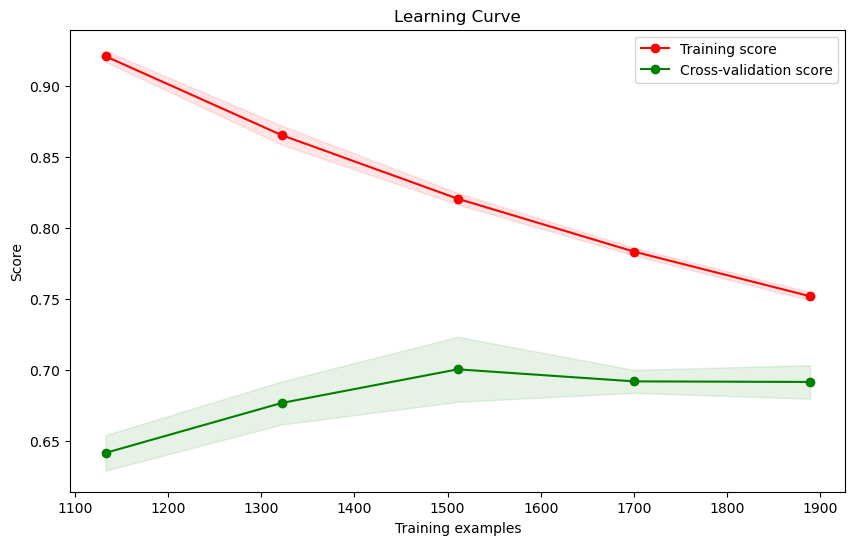

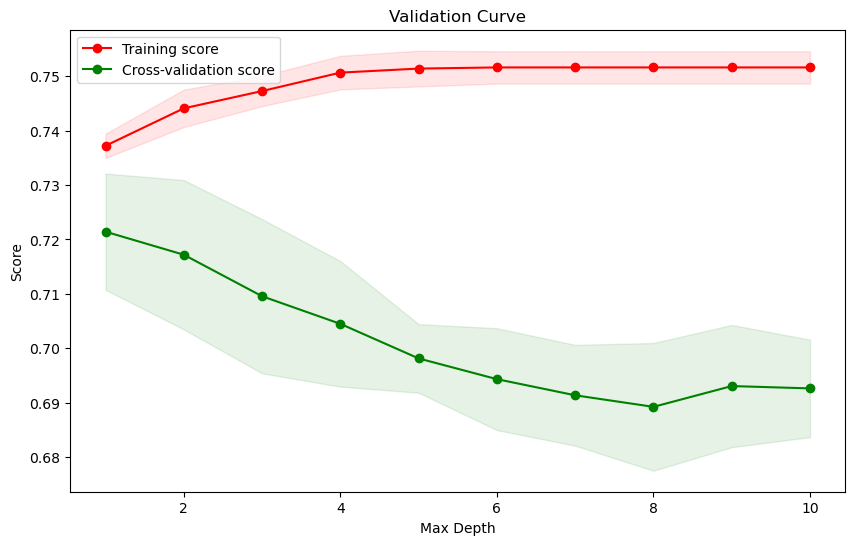

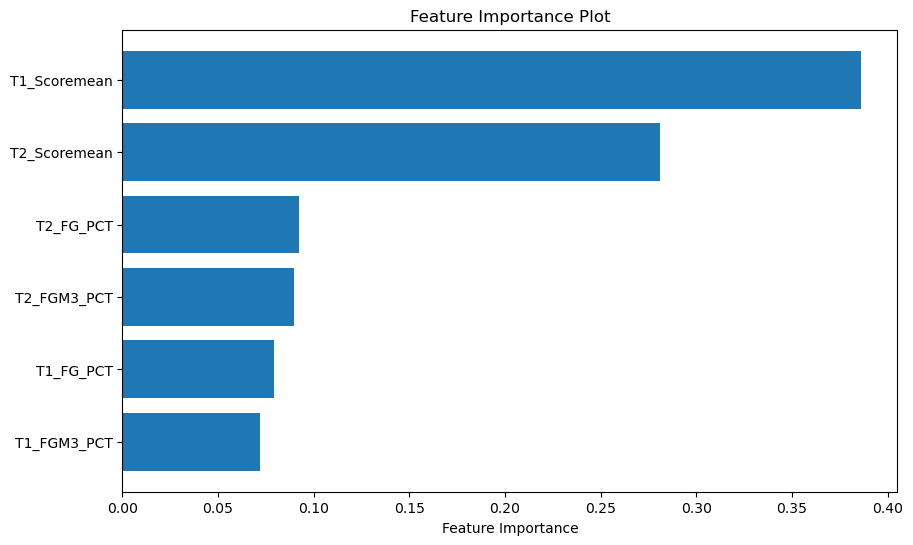

NameError: name 'XGBRegressor' is not defined

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import mean_squared_error

# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Validation Curve
param_range = np.arange(1, 11)
train_scores, valid_scores = validation_curve(model, X, y, param_name="max_depth", param_range=param_range, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.title("Validation Curve")
plt.legend(loc="best")
plt.show()

# Feature Importance Plot
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

# Residual Plot (if regression)
if isinstance(model, XGBRegressor):
    y_pred = model.predict(X)
    residuals = y - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()


# XGBoost RUN 2

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load your dataframe
df = tournament_data.copy()

# Add additional features if needed
# For example, you can add interactions between features, polynomial features, or other derived features

# Select features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 
                     'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 
                     'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 
                     'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean','T1_FG_PCT',
                     'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = XGBClassifier()

# Define hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7082452431289641


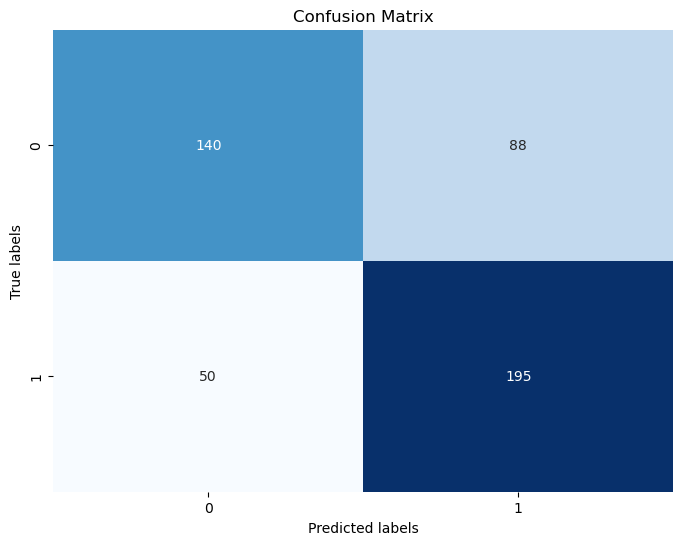

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


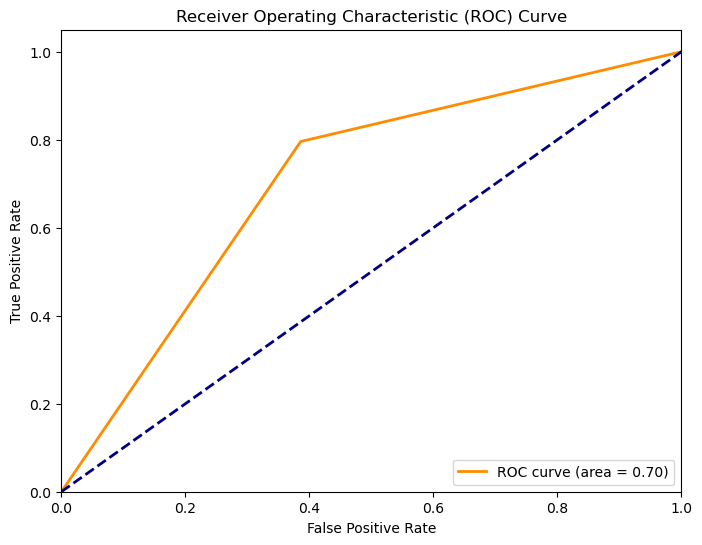

In [77]:
from sklearn.metrics import roc_curve, auc

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


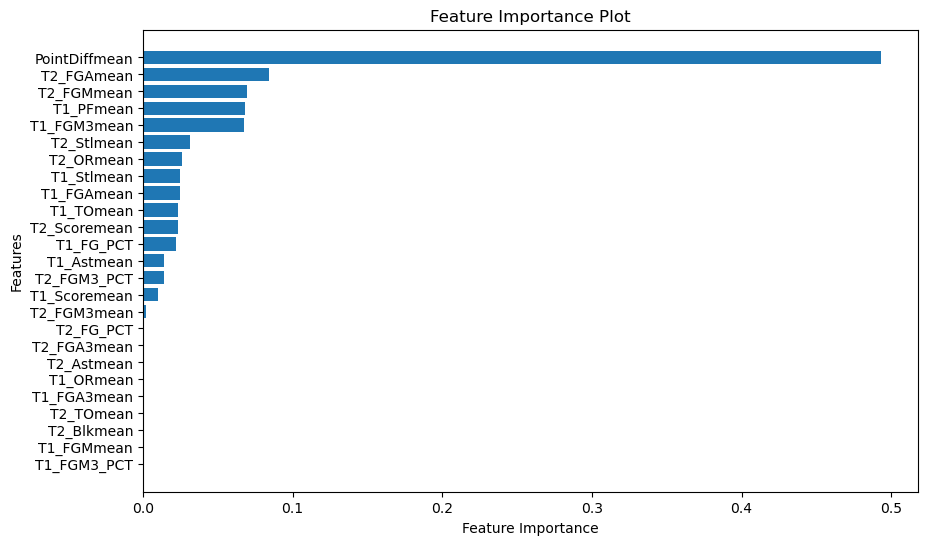

In [78]:
# Plot feature importance
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()


# XGBoost RUN 3

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Load your dataframe
df = tournament_data.copy()

label_encoder = LabelEncoder()

# Encode the 'T1_TeamSeed' and 'T2_TeamSeed' columns
df['T1_TeamSeed'] = label_encoder.fit_transform(df['T1_TeamSeed'])
df['T2_TeamSeed'] = label_encoder.fit_transform(df['T2_TeamSeed'])


# Feature engineering: Add new features or transform existing ones
# For example, you can try adding interactions between features or polynomial features

# Select features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FG_PCT', 'T1_FGM3_PCT', 'T2_FG_PCT', 'T2_FGM3_PCT', 'PointDiffmean', 'T1_TeamSeed', 'T2_TeamSeed']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Initialize the XGBoost model
model = XGBClassifier()

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Improved Accuracy:", accuracy)


KeyError: 'T1_TeamSeed'

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Plot feature importance
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()


# Run 4

In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Load your dataframe
df = tournament_data.copy()

label_encoder = LabelEncoder()

# Encode the 'T1_TeamSeed' and 'T2_TeamSeed' columns
df['T1_TeamSeed'] = label_encoder.fit_transform(df['T1_TeamSeed'])
df['T2_TeamSeed'] = label_encoder.fit_transform(df['T2_TeamSeed'])


# Feature engineering: Add new features or transform existing ones
# For example, you can try adding interactions between features or polynomial features

# Select features
selected_features = ['T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean',
       'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean',
       'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T2_FGMmean', 'T2_FGAmean',
       'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean',
       'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean', 'T1_FGPCTmean',
       'T1_3PCTmean', 'T1_FTPCTmean', 'T1_ORBCHANCEmean', 'T1_ORPCTmean',
       'T2_FGPCTmean', 'T2_3PCTmean', 'T2_FTPCTmean', 'T2_ORBCHANCEmean',
       'T2_ORPCTmean', 'T1_TeamSeedCorrmean', 'T2_TeamSeedCorrmean',
       'T1__adj_omean', 'T1__adj_dmean', 'T1__adj_tempomean', 'T1__luckmean',
       'T1__sos_adj_omean', 'T1__sos_adj_dmean', 'T2__adj_omean',
       'T2__adj_dmean', 'T2__adj_tempomean', 'T2__luckmean',
       'T2__sos_adj_omean', 'T2__sos_adj_dmean']

# Extract the features and target variable
X = df[selected_features]
y = df['Outcome']  # Assuming 'Outcome' indicates the winner (1 for Team 1, 0 for Team 2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Initialize the XGBoost model
model = XGBClassifier()

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Improved Accuracy:", accuracy)

KeyError: 'T1_TeamSeed'